# Six Southern Labor Markets #3
### Education and school enrollment

February 4, 2019

Brian Dew, @bd_econ

-----

Look at what share of age 25-54 population, for men and women separately, is in each of five educational categories: 1) less than high school, 2) high school or GED, 3) some college or associate degree, 4) bachelor's degree, and 5) advanced degree. Look at how it compares to national average.

Then look at what share of young people, (age 18-24, men and women separately) are enrolled in college. 

Areas:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- US total

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
areas = [('Chattanooga-Cleveland-Dalton, TN-GA', 'CSA', [174]),
         ('Greenville-Anderson-Spartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-Kingsport-Bristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [3]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('Six areas combined', 'CSA in @csa or CBSA in @cbsa'),
        ('Other south', 'REGION == "South" and CSA not in @csa and CBSA not in @cbsa'),
        ('Other US', 'CSA not in @csa and CBSA not in @cbsa'),
        ('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

### Educational groups

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'PWSSWGT', 'EDUC', 'FEMALE']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2017, 2018]])

In [5]:
groups_selected = groups
del groups_selected[6:9]

In [6]:
results = pd.DataFrame()
for group in groups_selected:
    data = df.query(group[1])
    total = data.query('25 <= AGE <= 54')
    i = total.groupby('EDUC').PWSSWGT.sum()
    s = ((i / total.PWSSWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Total'
        results.at[row_name, idx] = val
    men = data.query('25 <= AGE <= 54 and FEMALE == 0')
    i = men.groupby('EDUC').PWSSWGT.sum()
    s = ((i / men.PWSSWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Men'
        results.at[row_name, idx] = val
    women = data.query('25 <= AGE <= 54 and FEMALE == 1')
    i = women.groupby('EDUC').PWSSWGT.sum()
    s = ((i / women.PWSSWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Women'
        results.at[row_name, idx] = val
        
#reorder results
results = results[['LTHS', 'HS', 'SC', 'COLL', 'ADV']]

### Clean up education data for custom chart

In [7]:
# Custom sort - most advanced degrees first, US total last
filter_list = [area for area in list(results.index) 
               if 'US' not in area and 'Total' in area]
sorted_list = list(results.loc[filter_list]
                          .sort_values(by='ADV')
                          .index)
sorted_names = [i.replace(', Total', '') for i in sorted_list]

m_w_list = [(i.replace('Total', 'Men'), i.replace('Total', 'Women'))
            for i in sorted_list]
temp_list = [('US Total, Men', 'US Total, Women')] + m_w_list
col_list = list(sum(temp_list, ()))

results = results.loc[col_list]

areas = ['US Total'] + sorted_names

In [8]:
# Get start location for each bar segment
temp = results.cumsum(axis=1).iloc[:,:-1]
temp['start'] = 0
temp = temp[['start', 'LTHS', 'HS', 'SC', 'COLL']]
start_locs = temp.rename({'start': 'LTHS', 'LTHS': 'HS', 'HS': 'SC', 
                          'SC': 'COLL', 'COLL': 'ADV'}, axis=1)

# Get length of each bar segment
len_locs = results

# Get y values for each bar (with blank space for label)
y_values = []
i = 0.0
for _ in range(7):
    y_values.extend([i, i+1])
    i = i + 2.8

# Color for each educational group (red, blue, green, purple, orange)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

# Combine educational group names with colors
educ_groups = list(zip(colors, ['LTHS', 'HS', 'SC', 'COLL', 'ADV']))

In [9]:
# Main city name labels
label_y_locs = [y + 2 for y in y_values[::2]]
area_labels = list(zip(areas, label_y_locs))

# Men/ Women labels
label_y_locs = y_values
label_text = ['M', 'F'] * 7
mw_labels = list(zip(label_y_locs, label_text))

### Education chart

In [10]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

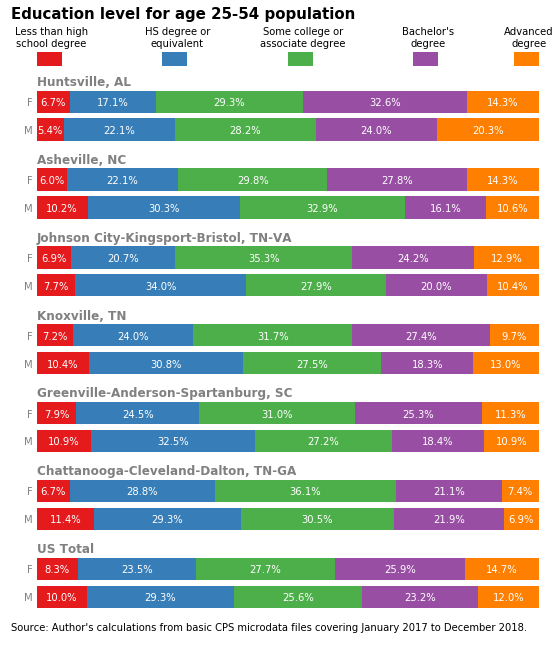

In [11]:
# Very custom stacked horizontal bar chart
fig = plt.figure(figsize=(9,11))

plt.ylim(-0.5, 21)
plt.xlim(0, 100)

ax = plt.gca()
    
for color, educ_level in educ_groups:
    bar_segments = []
    start_loc = start_locs[educ_level].values
    len_loc = len_locs[educ_level].values
    data = list(zip(start_loc, len_loc, y_values))
    for seg in data:
        rect = Rectangle((seg[0], seg[2]), seg[1], 0.8)
        bar_segments.append(rect)
        
        # Put data value text at bar midpoint
        text_x_val = (seg[1] / 2 + seg[0])
        text_y_val = seg[2] + 0.275
        text_val = f'{round(seg[1], 1)}%'
        plt.text(text_x_val, text_y_val, text_val,
                 fontsize=10, color='white', ha='center')

    bars = PatchCollection(bar_segments, facecolor=color, edgecolor='none')
                        
    ax.add_collection(bars)

for name, y_loc in area_labels:
    plt.text(0, y_loc, name, fontsize=12, color='gray', weight='bold')

for y_loc, name in mw_labels:
    plt.text(-0.8, y_loc + 0.275, name, fontsize=10, color='gray', ha='right')
    
# Custom legend at top of plot
plt.text(3, 20.2, 'Less than high\nschool degree', ha='center')
rect = Rectangle((0, 19.5), 5, 0.5, facecolor='#e41a1c', edgecolor='none')
ax.add_patch(rect)

plt.text(28, 20.2, 'HS degree or\nequivalent', ha='center')
rect = Rectangle((25, 19.5), 5, 0.5, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(53, 20.2, 'Some college or\nassociate degree', ha='center')
rect = Rectangle((50, 19.5), 5, 0.5, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)

plt.text(78, 20.2, "Bachelor's\ndegree", ha='center')
rect = Rectangle((75, 19.5), 5, 0.5, facecolor='#984ea3', edgecolor='none')
ax.add_patch(rect)

plt.text(98, 20.2, 'Advanced\ndegree', ha='center')
rect = Rectangle((95, 19.5), 5, 0.5, facecolor='#ff7f00', edgecolor='none')
ax.add_patch(rect)

# add title and footer
plt.text(-5, 21.2, 'Education level for age 25-54 population', 
          fontsize=15, weight='bold')

plt.text(-5, -0.8, "Source: Author's calculations from basic CPS microdata files covering January 2017 to December 2018.")
#plt.text(-8.5, -1.3, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('education.png', bbox_inches='tight');

### School enrollment among 18-24 year olds

In [12]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'PWSSWGT', 'SCHENR', 'FEMALE']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2015, 2016, 2017, 2018]])

In [13]:
areas = [('Chattanooga-\nCleveland-\nDalton, TN-GA', 'CSA', [174]),
         ('Greenville-\nAnderson-\nSpartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-\nKingsport-\nBristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [14]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('Six areas combined', 'CSA in @csa or CBSA in @cbsa'),
        ('Other south', 'REGION == "South" and CSA not in @csa and CBSA not in @cbsa'),
        ('Other US', 'CSA not in @csa and CBSA not in @cbsa'),
        ('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

In [15]:
groups_selected = groups
del groups_selected[6:9]

In [16]:
results = pd.DataFrame()
total = pd.Series()
for group in groups_selected:
    data = df.query(group[1])
    men = data.query('18 <= AGE <= 24 and SCHENR in [0, 1] and FEMALE == 0')
    i = men.groupby('SCHENR').PWSSWGT.sum()
    s = ((i / men.PWSSWGT.sum()) * 100)
    results.at[group[0], 'Men'] = s[1]
    women = data.query('18 <= AGE <= 24 and SCHENR in [0, 1] and FEMALE == 1')
    i = women.groupby('SCHENR').PWSSWGT.sum()
    s = ((i / women.PWSSWGT.sum()) * 100)
    results.at[group[0], 'Women'] = s[1]
    tot = data.query('18 <= AGE <= 24 and SCHENR in [0, 1]')
    i = tot.groupby('SCHENR').PWSSWGT.sum()
    s = ((i / tot.PWSSWGT.sum()) * 100)
    total[group[0]] = s[1]

In [17]:
sort_order = list(total.sort_values().index)
results = results.loc[sort_order]

In [18]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

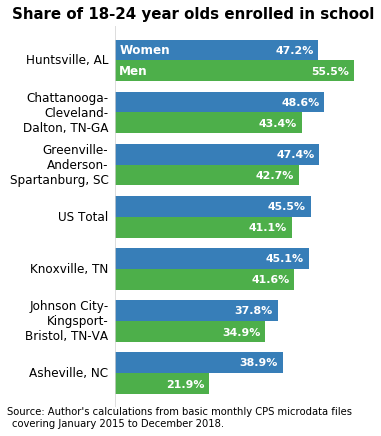

In [20]:
results.plot(kind='barh', figsize=(4.5, 7), legend=False,
             width=0.8, color=['#4daf4a', '#377eb8'])
for i, val in enumerate(results['Men']):
    x_val = val - 10
    color = 'white'
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.27
    plt.text(x_val, y_val, text_val, color=color, fontsize=11, weight='bold')
    plt.text(-1.5, i, results.index[i], ha='right', va='center', fontsize=12)
for i, val in enumerate(results['Women']):
    x_val = val - 10
    color = 'white'
    text_val = f'{round(val, 1)}%'
    y_val = i + 0.14
    plt.text(x_val, y_val, text_val, color=color, fontsize=11, weight='bold')

plt.text(1, 6.14, 'Women', color='white', fontsize=12, weight='bold')   
plt.text(1, 5.73, 'Men', color='white', fontsize=12, weight='bold')  
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-24, 6.8, 'Share of 18-24 year olds enrolled in school', 
          fontsize=15, weight='bold')

plt.text(-25, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-24, -1.03, 'covering January 2015 to December 2018.')

plt.axis('off')

plt.savefig('school_enrollment.png', bbox_inches='tight');